# Magnet Distance Notes

This notebooks contains my notes on determining magnet distance from the magnetic flux value, as the relationship between them isn't linear. The calculations here are based on the datasheets from the DRV5056.

![Magnet Dimensions](./magnet-distance/magnet-dimensions.png)

This formula can then be used to calculate the magnetic flux:

![Magnetic Flux Formula](./magnet-distance/magnetic-flux-formula.png)

The DRV5056 datasheet provided this magnetic profile for a 10mm x 6mm cylindrical ferrite magnet as reference:

![10mm x 6mm Cylindrical Magnet Profile](./magnet-distance/10x6-cylindrical-magnet.png)

In [99]:
# Imports
import numpy as np
from matplotlib import pyplot as plt

[71.93230414 69.89590061 67.91416263 65.9865631  64.11247356 62.2911756
 60.52187166 58.80369523 57.13572043 55.51697103 53.94642869 52.42304075
 50.94572726 49.51338751 48.12490593 46.77915744 45.47501234 44.2113406
 42.98701579 41.80091846 40.65193926 39.53898149 38.46096351 37.41682065
 36.40550696 35.42599657 34.47728495 33.55838979 32.66835181 31.80623534
 30.9711287  30.16214451 29.37841984 28.61911623 27.88341966 27.17054036
 26.4797126  25.81019445 25.16126737 24.53223585 23.922427   23.33119006
 22.75789592 22.20193663 21.66272483 21.13969328 20.63229423 20.13999895
 19.66229714 19.19869636 18.74872152 18.31191431 17.88783267 17.47605027
 17.07615597 16.68775329 16.31045999 15.94390747 15.58774039 15.24161613
 14.90520439 14.57818671 14.26025607 13.95111648 13.65048254 13.35807908
 13.07364078 12.7969118  12.52764544 12.2656038  12.01055741 11.76228497
 11.52057303 11.28521568 11.05601426 10.83277712 10.61531934 10.40346246
 10.19703426  9.99586853  9.79980482  9.60868823  9.4

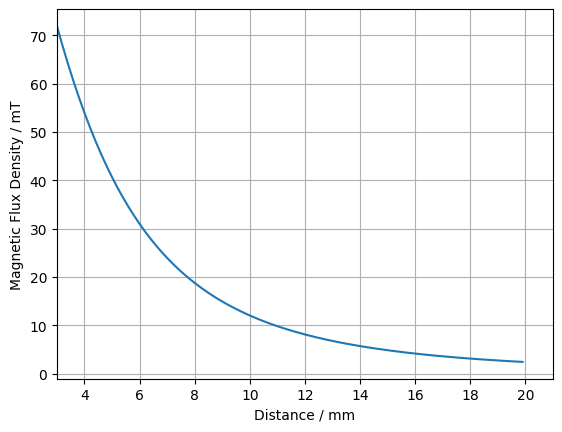

In [100]:
# Attempt to replicate the datasheet calculations
residual = 400 / 2.0    # In Millitesla
thickness = 6.0
diameter = 10.0
distances = np.arange(3, 20, 0.1)

radius_squared = (0.5 * diameter) ** 2

# Left fraction
lhs_numerator = distances + thickness
lhs_denominator = np.sqrt(radius_squared + (distances + thickness) ** 2)
lhs = lhs_numerator / lhs_denominator

# Right fraction
rhs_denominator = np.sqrt(radius_squared + (distances ** 2))
rhs = distances / rhs_denominator

# Calculate the final magnetic profile
magnetic_profile = residual * (lhs - rhs)

print(magnetic_profile)

plt.grid()
plt.xlim(3.0, 21.0)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, magnetic_profile)
plt.show()

[71.93230414 69.89590061 67.91416263 65.9865631  64.11247356 62.2911756
 60.52187166 58.80369523 57.13572043 55.51697103 53.94642869 52.42304075
 50.94572726 49.51338751 48.12490593 46.77915744 45.47501234 44.2113406
 42.98701579 41.80091846 40.65193926 39.53898149 38.46096351 37.41682065
 36.40550696 35.42599657 34.47728495 33.55838979 32.66835181 31.80623534
 30.9711287  30.16214451 29.37841984 28.61911623 27.88341966 27.17054036
 26.4797126  25.81019445 25.16126737 24.53223585 23.922427   23.33119006
 22.75789592 22.20193663 21.66272483 21.13969328 20.63229423 20.13999895
 19.66229714 19.19869636 18.74872152 18.31191431 17.88783267 17.47605027
 17.07615597 16.68775329 16.31045999 15.94390747 15.58774039 15.24161613
 14.90520439 14.57818671 14.26025607 13.95111648 13.65048254 13.35807908
 13.07364078 12.7969118  12.52764544 12.2656038  12.01055741 11.76228497
 11.52057303 11.28521568 11.05601426 10.83277712 10.61531934 10.40346246
 10.19703426  9.99586853  9.79980482  9.60868823  9.4

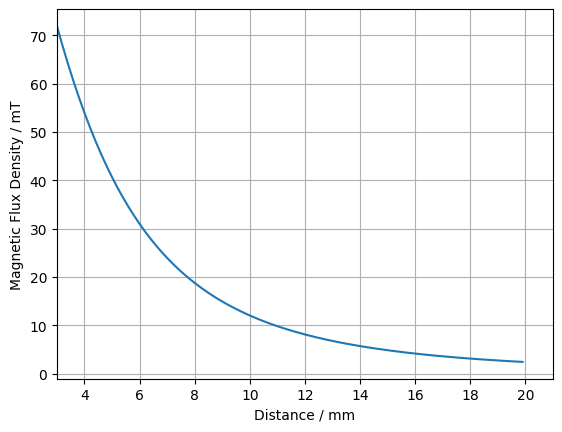

In [101]:
# Convert this into a re-usable function
def get_cylindrical_magnetic_profile(residual, thickness, diameter, distances):
    """ Function to calculate the magnetic profile for a cylindrical magnet. """
    residual = residual / 2.0
    radius_squared = (diameter / 2.0) ** 2
    
    # Left fraction
    lhs_numerator = distances + thickness
    lhs_denominator = np.sqrt(radius_squared + (distances + thickness) ** 2)
    lhs = lhs_numerator / lhs_denominator

    # Right fraction
    rhs_denominator = np.sqrt(radius_squared + (distances ** 2))
    rhs = distances / rhs_denominator

    return residual * (lhs - rhs)

distances = np.arange(3.0, 20.0, 0.1)
datasheet_profile = get_cylindrical_magnetic_profile(400, 6.0, 10.0, distances)

print(datasheet_profile)

plt.grid()
plt.xlim(3.0, 21.0)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, datasheet_profile)
plt.show()

## KS-20 Magnetic Profile

- Cylindrical Permanent Magnet
  - Thickness: 3.5mm
  - Diameter: 2.8mm
- PCB Thickness: 1.6mm
- Distance from Bottom of Chip: [1.9mm, 5.9mm]
  - Initial Position: 0.3mm from top of switch

[89.61758345 85.92672237 82.42588937 79.1040225  75.95071319 72.95617536
 70.11121399 67.40719396 64.83600913 62.39005228 60.06218598 57.84571442
 55.73435659 53.72222059 51.8037793  49.97384724 48.22755884 46.56034785
 44.96792805 43.44627511 41.99160957 40.6003809  39.26925265 37.99508843
 36.77493899 35.60603    34.48575074 33.4116435  32.38139376 31.39282094
 30.44386986 29.53260271 28.65719164 27.81591179 27.0071348  26.22932278
 25.48102272 24.76086115 24.06753933 23.39982861 22.75656621 22.13665121
 21.53904082 20.96274694 20.40683289 19.87041036 19.35263663 18.85271183
 18.36987653 17.90340938 17.45262495 17.01687168 16.59552995 16.18801035
 15.79375194 15.4122207  15.04290806 14.68532948 14.3390232  14.00354897
 13.67848691 13.36343643 13.05801523 12.76185831 12.47461711 12.19595861
 11.92556457 11.66313077 11.40836629 11.16099284 10.92074413 10.68736528
 10.46061227 10.24025135 10.02605863]


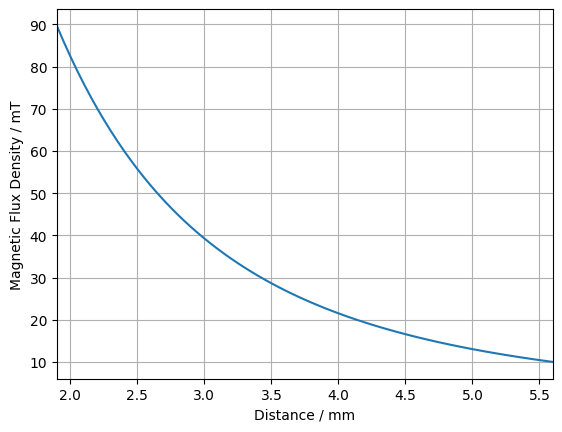

In [102]:
# At min distance (1.9mm), the magnetic flux is 905G, or 90.5mT
# At the initial position (5.6mm), the magnetic flux is 102G, or 10.2mT
# The values are a bit off, but should be close enough to the datasheet values
remanance_mt = 1100
thickness = 3.5
diameter = 2.8

min_distance = 1.9
max_distance = 5.6
step = 0.05

distances = np.arange(min_distance, max_distance + step, step)
ks20_profile = get_cylindrical_magnetic_profile(remanance_mt, thickness, diameter, distances)

print(ks20_profile)

plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, ks20_profile)
plt.show()

[78.         78.         78.         78.         75.95071319 72.95617536
 70.11121399 67.40719396 64.83600913 62.39005228 60.06218598 57.84571442
 55.73435659 53.72222059 51.8037793  49.97384724 48.22755884 46.56034785
 44.96792805 43.44627511 41.99160957 40.6003809  39.26925265 37.99508843
 36.77493899 35.60603    34.48575074 33.4116435  32.38139376 31.39282094
 30.44386986 29.53260271 28.65719164 27.81591179 27.0071348  26.22932278
 25.48102272 24.76086115 24.06753933 23.39982861 22.75656621 22.13665121
 21.53904082 20.96274694 20.40683289 19.87041036 19.35263663 18.85271183
 18.36987653 17.90340938 17.45262495 17.01687168 16.59552995 16.18801035
 15.79375194 15.4122207  15.04290806 14.68532948 14.3390232  14.00354897
 13.67848691 13.36343643 13.05801523 12.76185831 12.47461711 12.19595861
 11.92556457 11.66313077 11.40836629 11.16099284 10.92074413 10.68736528
 10.46061227 10.24025135 10.02605863]


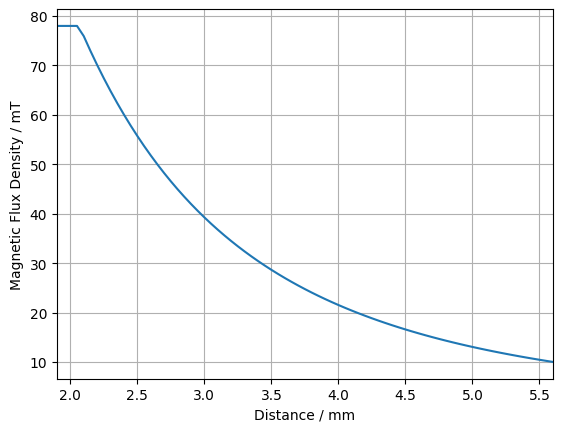

In [103]:
# If we clamp the maximum flux density to 78mT, we can find the minimum distance that can be detected
# In ideal conditions, we won't be able to detect the bottom 0.2mm of travel
ks20_profile_clamped = np.clip(ks20_profile, 0.0, 78.0)
print(ks20_profile_clamped)

plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, ks20_profile_clamped)
plt.show()

[3288.52750341 3177.80167108 3072.77668116 2973.12067497 2878.52139582
 2788.68526068 2703.33641982 2622.21581882 2545.08027382 2471.70156854
 2401.86557928 2335.37143245 2272.03069757 2211.66661783 2154.11337904
 2099.21541732 2046.82676521 1996.81043547 1949.03784154 1903.38825333
 1859.74828702 1818.01142713 1778.07757944 1739.85265303 1703.24816982
 1668.18090005 1634.57252206 1602.349305   1571.44181279 1541.78462824
 1513.31609571 1485.97808131 1459.71574929 1434.47735367 1410.21404385
 1386.87968349 1364.4306815  1342.82583453 1322.02617989 1301.99485841
 1282.69698643 1264.09953627 1246.17122459 1228.8824082  1212.2049866
 1196.11231092 1180.57909881 1165.58135483 1151.09629587 1137.1022815
 1123.57874862 1110.50615033 1097.86589861 1085.64031061 1073.81255828
 1062.36662109 1051.28724175 1040.55988451 1030.17069613 1020.1064691
 1010.35460716 1000.90309279  991.74045676  982.85574932  974.23851322
  965.87875823  957.76693715  949.89392321  942.25098874  934.82978515
  927.622

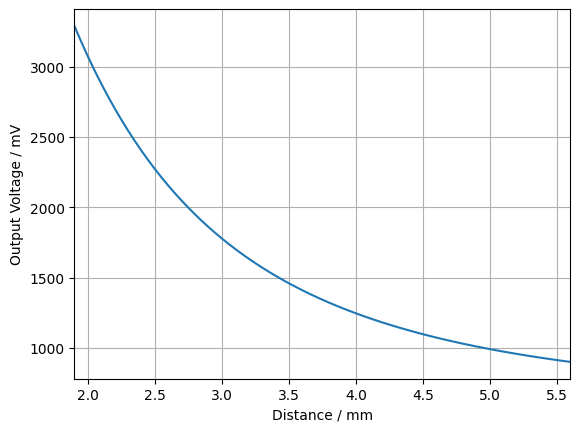

In [104]:
# Calculate the output voltage
quiescent_mv = 600
sensitivity_mv = 30
temperature = 25
ks20_mv = quiescent_mv + ks20_profile * (sensitivity_mv * (1 + 0.0012 * (temperature - 25)))

print(ks20_mv)
plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('Output Voltage / mV')
plt.plot(distances, ks20_mv)
plt.show()

[4081.76019817 3944.32595295 3813.96766244 3690.2734196  3572.85564766
 3461.3499478  3355.413932   3254.72605876 3158.98448532 3067.90594689
 2981.22467053 2898.69132949 2820.07204159 2745.14741413 2673.71163653
 2605.57162101 2540.546191   2478.46531627 2419.16939362 2362.50857141
 2308.34211626 2256.53781986 2206.97144406 2159.52620207 2114.09227382
 2070.56635351 2028.85122738 1988.85537978 1950.49262582 1913.68176887
 1878.34628122 1844.41400637 1811.81688155 1780.49067898 1750.37476473
 1721.4118738  1693.54790044 1666.7317025  1640.91491904 1616.05180002
 1592.0990474  1569.01566683 1546.76282907 1525.30374061 1504.60352276
 1484.62909864 1465.3490875  1446.73370587 1428.75467511 1411.38513485
 1394.59956192 1378.37369447 1362.68446082 1347.50991281 1332.82916324
 1318.62232727 1304.87046733 1291.5555415  1278.66035496 1266.16851438
 1254.06438513 1242.33305093 1230.96027602 1219.93246946 1209.23665156
 1198.86042234 1188.79193169 1179.01985135 1169.53334845 1160.3220606
 1151.3

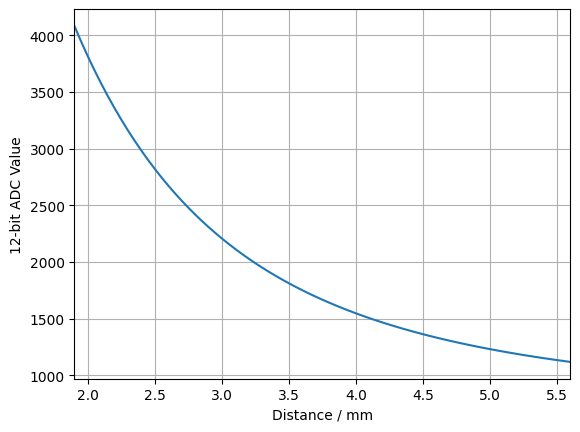

In [105]:
# Converting the voltages into 12-bit ADC values w/ 3.3V reference
ks20_adc = 4096 * (ks20_mv / 3300)

print(ks20_adc)
plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('12-bit ADC Value')
plt.plot(distances, ks20_adc)
plt.show()

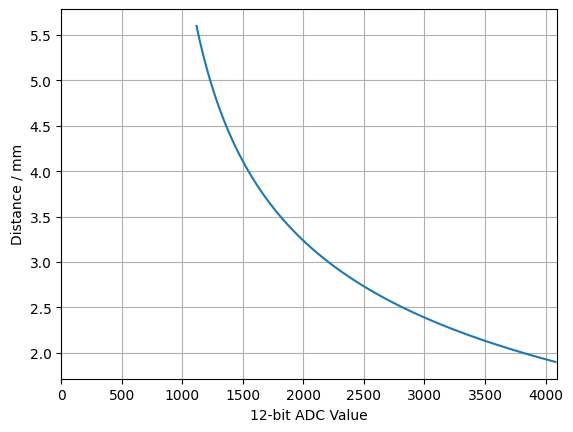

In [106]:
# If we plot in the other direction, we can come up with a lookup table for mapping ADC values -> distance
plt.grid()
plt.xlim(0, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(ks20_adc, distances)
plt.show()

[1.31284608e+01 1.18876071e-03 1.97447030e+00]


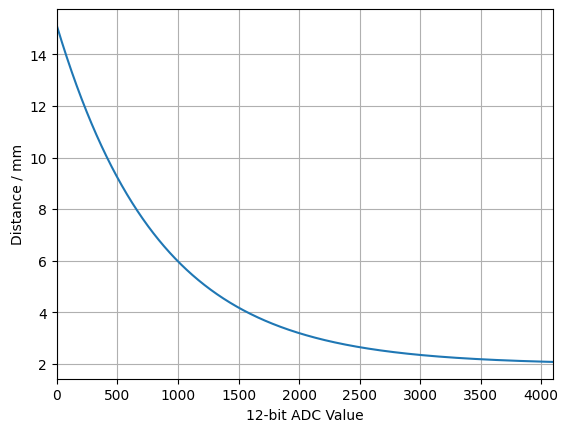

In [107]:
# An exponential function can be used for curve fitting
from scipy.optimize import curve_fit

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(exponential_func, ks20_adc, distances, p0=(1, 0.001, 2.55))
print(popt)

x = np.arange(0.0, 4096.0, 1.0)
y = exponential_func(x, *popt)

plt.grid()
plt.xlim(0.0, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(x, y)

[   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.  176.
  192.  208.  224.  240.  256.  272.  288.  304.  320.  336.  352.  368.
  384.  400.  416.  432.  448.  464.  480.  496.  512.  528.  544.  560.
  576.  592.  608.  624.  640.  656.  672.  688.  704.  720.  736.  752.
  768.  784.  800.  816.  832.  848.  864.  880.  896.  912.  928.  944.
  960.  976.  992. 1008. 1024. 1040. 1056. 1072. 1088. 1104. 1120. 1136.
 1152. 1168. 1184. 1200. 1216. 1232. 1248. 1264. 1280. 1296. 1312. 1328.
 1344. 1360. 1376. 1392. 1408. 1424. 1440. 1456. 1472. 1488. 1504. 1520.
 1536. 1552. 1568. 1584. 1600. 1616. 1632. 1648. 1664. 1680. 1696. 1712.
 1728. 1744. 1760. 1776. 1792. 1808. 1824. 1840. 1856. 1872. 1888. 1904.
 1920. 1936. 1952. 1968. 1984. 2000. 2016. 2032. 2048. 2064. 2080. 2096.
 2112. 2128. 2144. 2160. 2176. 2192. 2208. 2224. 2240. 2256. 2272. 2288.
 2304. 2320. 2336. 2352. 2368. 2384. 2400. 2416. 2432. 2448. 2464. 2480.
 2496. 2512. 2528. 2544. 2560. 2576. 2592. 2608. 26

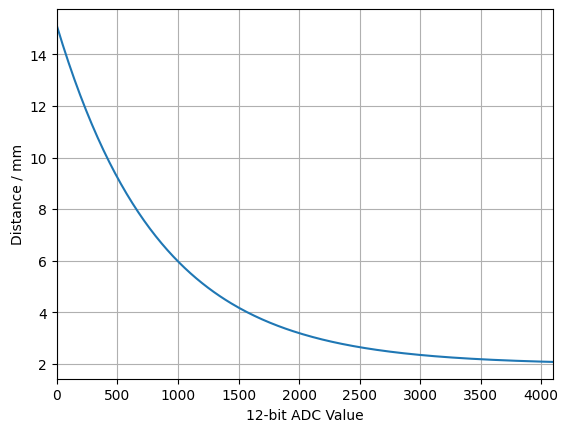

In [108]:
# A lookup table can then be generated from these values
# An extra value is needed for the maximum possible entry; this eliminates having to wrap around when performing lookups
lookup_bits = 4
lookup_step = 2 ** lookup_bits
lookup_x = np.arange(0, 4096.0 + lookup_step, lookup_step)
lookup_y = exponential_func(lookup_x, *popt)

print(lookup_x)
print(lookup_y)

plt.grid()
plt.xlim(0.0, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(lookup_x, lookup_y)

In [109]:
# Using the lookup table and linear interpolation, we can find the distance for a particular ADC value
# Max allowed value is 4095
def distance_lerp(adc):
    lut_index = int(adc / lookup_step)

    adc0 = lut_index * lookup_step
    adc1 = adc0 + lookup_step

    dist0 = lookup_y[lut_index]
    dist1 = lookup_y[lut_index + 1]

    distance_lerp = dist0 + (dist1 - dist0) * (adc - adc0) / lookup_step

    print('ADC Value:', adc)
    print('LUT Index:', lut_index)
    print(f'Between ({adc0}, {dist0}) and {adc1, dist1}')
    print('Interpolated Distance:', distance_lerp)

# These values can be used as the reference for top/bottom
distance_lerp(1142)
print()
distance_lerp(4095)

ADC Value: 1142
LUT Index: 71
Between (1136, 5.376425376899485) and (1152, 5.312331082779529)
Interpolated Distance: 5.3523900166045015

ADC Value: 4095
LUT Index: 255
Between (4080, 2.077230080352181) and (4096, 2.075294041978461)
Interpolated Distance: 2.0754150443768187
